## 稀疏性和L1正则化  


In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    #创建一个新的目标特征，即median_house_value_is_high
    #通过median_house_value是否大于265000来判断
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2642.0,537.6,1423.7,499.7,3.9,2.0
std,2.1,2.0,12.6,2201.4,425.3,1164.7,387.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1454.0,295.0,784.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2124.5,433.0,1160.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3139.0,644.0,1708.5,602.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2647.7,543.7,1443.6,504.8,3.9,2.0
std,2.1,2.0,12.7,2127.7,412.2,1106.3,377.4,1.9,1.0
min,32.5,-124.3,1.0,15.0,3.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1476.0,301.0,800.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2136.5,436.0,1184.5,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3173.2,658.2,1751.0,613.0,4.7,2.3
max,42.0,-114.5,52.0,32054.0,5290.0,15507.0,5050.0,15.0,17.4


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [4]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
#定义一个桶
def get_quantile_based_buckets(feature_values, num_buckets):
    quantiles = feature_values.quantile(
        [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
    return [quantiles[q] for q in quantiles.keys()]

In [8]:
def construct_feature_columns():

    bucketized_households = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("households"),
        boundaries=get_quantile_based_buckets(training_examples["households"], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("longitude"),
        boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("latitude"),
        boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("housing_median_age"),
        boundaries=get_quantile_based_buckets(
          training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_rooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_bedrooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("population"),
        boundaries=get_quantile_based_buckets(training_examples["population"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("median_income"),
        boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("rooms_per_person"),
        boundaries=get_quantile_based_buckets(
          training_examples["rooms_per_person"], 10))

    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

    feature_columns = set([
        long_x_lat,
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_total_rooms,
        bucketized_total_bedrooms,
        bucketized_population,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])
  
    return feature_columns

### 计算模型大小  
只需计算非零参数的数量即可。这里使用一个深入使用Estimator API的辅助函数。

In [24]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable 
                    for x in ['global_step',
                             'centered_bias_weight',
                             'bias_weight',
                             'Ftrl']
                      ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

### 减少模型大小  
针对SmartRing构建一个准确度高的逻辑回归模型。这个指环可以感应城市街区的人口统计特征，并告诉我们指定城市街区的住房是否高。  


查找合适的正则化系数，满足：  
* 模型的参数数量不超过 600 个
* 验证集的对数损失函数低于 0.35。  
使用 FtrlOptimizer 来应用正则化。FtrlOptimizer 是一种设计成使用 L1 正则化,并且比标准梯度下降法得到更好结果的方法。

In [25]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 7
    steps_per_period = steps / periods

  # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
  # Create input functions  
    training_input_fn = lambda: my_input_fn(training_examples, 
                                training_targets["median_house_value_is_high"], 
                                batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                training_targets["median_house_value_is_high"], 
                                        num_epochs=1, 
                                        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                 validation_targets["median_house_value_is_high"], 
                                        num_epochs=1, 
                                        shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.31
  period 01 : 0.28
  period 02 : 0.26
  period 03 : 0.25
  period 04 : 0.24
  period 05 : 0.24
  period 06 : 0.23
Model training finished.
Model size: 752


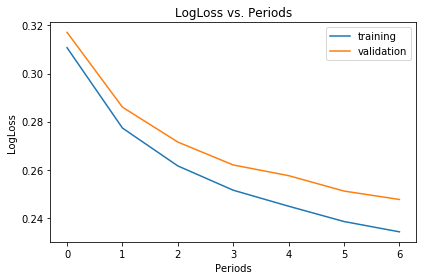

In [27]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))